# Regresión lineal: Ejemplo sintético con Scikit-learn
M2U3 - Ejercicio 6

## ¿Qué vamos a hacer?
- Resolver un modelo de regresión lineal multivariable usando Scikit-learn.

Recuerda seguir las instrucciones para las entregas de prácticas indicadas en [Instrucciones entregas](https://github.com/Tokio-School/Machine-Learning/blob/main/Instrucciones%20entregas.md).

## Instrucciones

Una vez desarrollada una implementación a mano del algoritmo de regresión lineal multivariable con Numpy exclusivamente, hemos podido ver en profundidad los pasos a seguir, cómo funciona el algoritmo matemático interno, y cómo le afectan todos los hiper-parámetros.

Habiendo entendido bien entonces cómo funcionan dichos modelos de ML, vamos a ver cómo utilizarlos con las funciones del framework de ML de Scikit-learn.

En este ejercicio tendrás una plantilla en blanco con los pasos que hemos seguido en ejercicios anteriores, que tendrás que completar con tu código siguiendo dichos pasos, pero esta vez usando métodos de Scikit-learn.

En cada celda te sugeriremos una función de Scikit-learn que puedes usar. No te daremos más información aquí sobre ella, porque queremos que la busques por ti mismo en la documentación: su funcionamiento, algoritmos que implementa (algunos serán ligeramente diferentes a los que hemos visto en el curso, no te preocupes puesto que lo importante es la base), argumentos, ejemplos, etc.

Parece de perogrullo, pero seguro que estarás de acuerdo con nosotros que la habilidad de saber encontrar la información relevante en cada momento en la documentación es muy importante, y muchas veces nos puede costar algo más de lo debido :).

Aprovecha también para bucear más en la documentación y descubrir aspectos interesantes del framework. Seguiremos trabajando con él en ejercicios posteriores.

In [1]:
# TODO: Importa todos los módulos necesarios en esta celda

import numpy as np

from matplotlib import pyplot as plt
from sklearn.datasets import make_regression
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import RidgeCV



## Crear un dataset sintético para regresión lineal

- Añádele un término de bias y de error modificable.

In [2]:
# TODO: Crea un dataset sintético para regresión lineal con Scikit-learn

X, y, coef = make_regression(n_samples=1000, n_features=3, noise=0.5, bias=1.0, coef=True, random_state=42)


## Preprocesar los datos

- Reordenarlos aleatoriamente.
- Normalizarlos.
- Dividirlos en subsets de entrenamiento y test.

*Nota*: ¿Por qué esta vez usamos 2 subsets de entrenamiento y test únicamente, sin subset de validación? Porque usaremos *k-fold* para nuestra validación cruzada.

In [3]:
# TODO: Reordena los datos aleatoriamente
X, y = shuffle(X, y, random_state=42)

In [4]:
# TODO: Normaliza los ejemplos
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

*Nota*: Este escalado es equivalente al normalizado básico que hemos visto durante el curso. Otra normalización más conveniente en modelos más avanzados pero más compleja de entender sería la implementada en *sklearn.preprocessing.normalize*.

Puedes encontrar todos las clases y funciones de preprocesamiento disponibles aquí: [Sklearn docs: 6.3. Preprocessing data](https://scikit-learn.org/stable/modules/preprocessing.html)

Y una comparativa gráfica: [Compare the effect of different scalers on data with outliers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html)

In [5]:
# TODO: Divide el dataset en los subsets de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Entrenar un modelo inicial

- Entrena un modelo inicial sobre el subset de entrenamiento sin regularización.
- Comprueba la idoneidad del modelo.
- Comprueba si existe desviación o sobreajuste.

Para entrenar un modelo simple de regresión lineal multivariable, puedes usar la clase [sklearn.linear_model.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

Puedes consultar un ejemplo completo de entrenamiento: [Linear Regression Example](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py)

In [6]:
# TODO: Entrena un modelo de regresión lineal base sobre el subset de entrenamiento sin regularización
# Ajusta el término de intercept/bias y no normalices las características, puesto que las hemos normalizado ya
model = LinearRegression(fit_intercept=False).fit(X_train, y_train)

Comprueba la idoneidad del modelo aplicado a este dataset. Para ello puedes usar:
- El coeficiente de determinación R^2 del método [LinearRegression.score()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score)
- La función [sklearn.metrics.mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error) (permite devolver el MSE o RMSE)
- Otras [métricas para regresión](https://scikit-learn.org/stable/modules/classes.html#regression-metrics)

Prueba varios de los métodos para conocerlos mejor y ver sus posibles diferencias:

In [7]:
# TODO: Comprueba la idoneidad del modelo evaluándolo sobre el set de test
y_pred = model.predict(X_test)

r2 = model.score(X_test, y_test)

mse = mean_squared_error(y_test, y_pred)

mae = mean_absolute_error(y_test, y_pred)

print("R²:", r2)
print("MSE:", mse)
print("MAE:", mae)

R²: 0.9976101458143491
MSE: 38.355896810638626
MAE: 6.17017345301342


Para comprobar si pudiera existir desviación o sobreajuste, podemos calcular p. ej. el RMSE sobre las predicciones del subset de entrenamiento y sobre las del de test:

In [8]:
# TODO: Comprueba si la evaluación sobre ambos subsets es similar con el RMSE
y_train_pred = model.predict(X_train)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test  = np.sqrt(mean_squared_error(y_test, y_pred))

print("RMSE Train:", rmse_train)
print("RMSE Test:", rmse_test)

RMSE Train: 6.148230223174236
RMSE Test: 6.193213770784812


## Hallar la regularización óptima por validación cruzada o *k-fold*

- Entrena un modelo por cada valor de regularización a considerar.
- Entrénalos y evalúalos sobre una divisón del subset de entrenamiento por K-fold.
- Escoge el modelo y su regularización óptimos.

Ahora vamos a usar un algoritmo de regresión lineal más complejo, la clase [sklearn.linear_model.Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) que nos permite establecer un parámetro de regularización L2.

En esta función, el argumento de regularización se denomina *alpha*, aunque no debemos confundirlo con el ratio de aprendizaje.

La regularización que hemos visto durante el curso es la que implementan la mayoría de algoritmos de Scikit-learn, siendo su denominación común "L2" o "L2-norm" en inglés.

Considera unos parámetros de regularización L2 en el rango logarítmico: 0.1, 0.01, 0.001, 0.0001, etc.

Puedes guiarte por este enlace: [K-fold](https://scikit-learn.org/stable/modules/cross_validation.html#k-fold)

In [9]:
alphas = np.logspace(-1, -5, 5)

ridge_cv = RidgeCV(alphas=alphas, cv=5).fit(X_train, y_train)

print("Mejor alpha:", ridge_cv.alpha_)
print("Score sobre train:", ridge_cv.score(X_train, y_train))
print("Score sobre test:", ridge_cv.score(X_test, y_test))

Mejor alpha: 0.001
Score sobre train: 0.9999851896832378
Score sobre test: 0.9999834300191347


## Evaluar el modelo finalmente sobre el subset de test

- Muestra los coeficientes e intercept del mejor modelo.
- Evalúa el mejor modelo sobre el subset de test inicial.
- Calcula los resíduos sobre el subset de test y represéntalos.

Coeficientes de intercept del modelo entrenado:
6.129651910084167 [99.1596287  79.44361596 25.47018099]
Raíz del error cuadrático medio (RMSE): 0.52
Coeficiente de determinación: 1.00


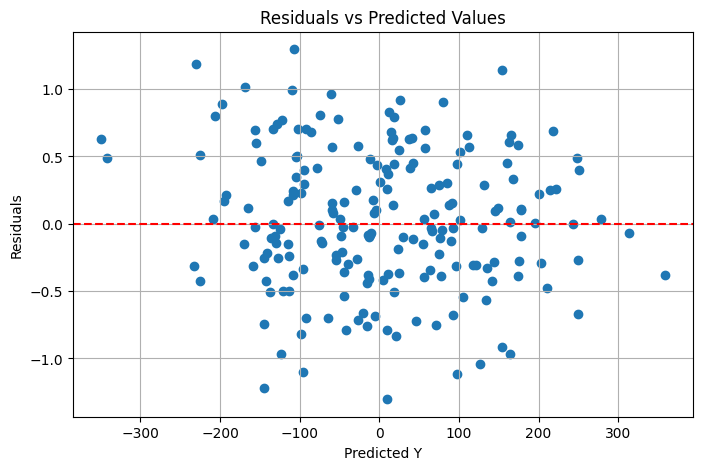

In [10]:
# TODO: Evalúa el mejor modelo sobre el subset de test inicial

# Muestra los coeficientes e intercept del mejor modelo entrenado
print('Coeficientes de intercept del modelo entrenado:')
print(ridge_cv.intercept_ ,ridge_cv.coef_)    # Muestra el intercept como el primer coeficiente

# Realiza las predicciones sobre el subset de test
y_test_pred = ridge_cv.predict(X_test)

# Calcula las métricas de evaluación del modelo: RMSE y coeficiente de determinación R^2
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_test, y_test_pred)

print('Raíz del error cuadrático medio (RMSE): %.2f' % rmse)
print('Coeficiente de determinación: %.2f' % r2)

# Calcula los resíduos sobre el subset de test
residuals = y_test - y_test_pred

plt.figure(figsize=(8,5))
plt.scatter(y_test_pred, residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Y')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid(True)
plt.show()

## Realizar predicciones sobre nuevos ejemplos

- Genera un nuevo ejemplo siguiendo el mismo patrón del dataset original.
- Normaliza sus características.
- Genera una predicción para dicho ejemplo.

In [11]:
X_pred = np.array([[0.3, -0.5, 0.1]])
X_pred = scaler.transform(X_pred)
y_pred = ridge_cv.predict(X_pred)
print(y_pred)

[-7.86430471]
